In [1]:
# --- import ---
import os.path

import matplotlib.pyplot as plt
import numpy as np
from configs import ProjectConfigs
from scipy.signal import spectrogram
from utils import histogram2d
from utils import spectral

import pyaw.utils
from core import dmsp
from src.pyaw import plot_multi_panel, plot_gridded_panels

In [2]:

# --- file paths ---

data_dir_path = ProjectConfigs.data_dir_path
file_name_s3 = 'dmsp-f18_ssies-3_thermal-plasma_201401010124_v01.cdf'  # 一轨
file_name_ssm = 'dmsp-f18_ssm_magnetometer_20140101_v1.0.4.cdf'  # 1天
file_path_ssies3 = os.path.join(data_dir_path, file_name_s3)
file_path_ssm = os.path.join(data_dir_path, file_name_ssm)

In [3]:

# --- read data as df

ssies3_ssm = dmsp.SPDF.SSIES3CoupleSSM(file_path_ssies3, file_path_ssm)
df_whole = ssies3_ssm.ssies3_ssm_df
df = df_whole[df_whole['glat'] > 50].copy()

In [4]:

# --- set base datetimes
datetimes = df.index.values

In [5]:
##  --- choose a disturb magnetic field and electric field pair. delta_B: East, E: North
b_sc2 = df['b1_s3_sc2'].copy().ffill().bfill().values  # not use linear, because too many nan will cause large values
E_sc1 = df['E_s3_sc1'].copy().ffill().bfill().values
assert not np.isnan(b_sc2).any(), "have nan values"
assert not np.isnan(E_sc1).any(), "have nan values"


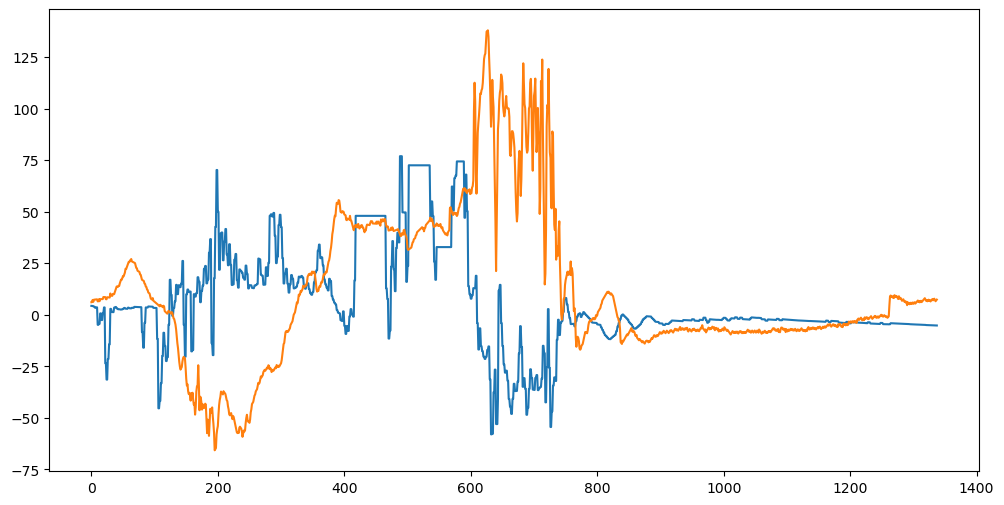

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(E_sc1)
plt.plot(b_sc2)

In [8]:
# --- spectrogram

## --- settings
fs = 1
window = "hann"
spectrogram_window_seconds = 4
nperseg = int(spectrogram_window_seconds * fs)
noverlap = nperseg // 2  # 重叠率一般为50%

In [9]:
## --- get spectrogram
frequencies, ts, Sxx_b = spectrogram(
    b_sc2,
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    mode="complex",
)
_, _, Sxx_e = spectrogram(
    E_sc1, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode="complex"
)

In [10]:

## --- get datetime type ndarray for the plot
ts_dt64 = datetimes[0] + [np.timedelta64(int(_), "s") for _ in ts]

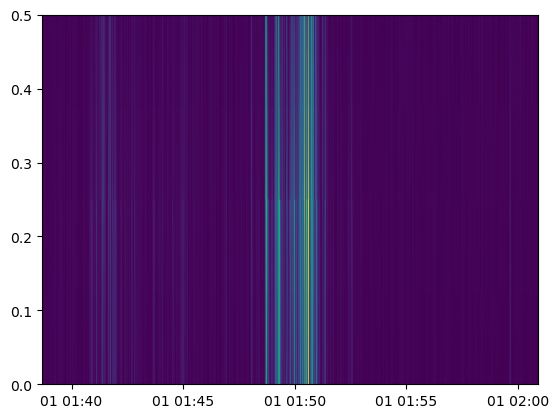

In [24]:
plt.pcolormesh(ts_dt64, frequencies, np.abs(Sxx_b), shading='gouraud')

In [21]:
np.percentile(np.abs(Sxx_e), 10)

0.0018985869479365646

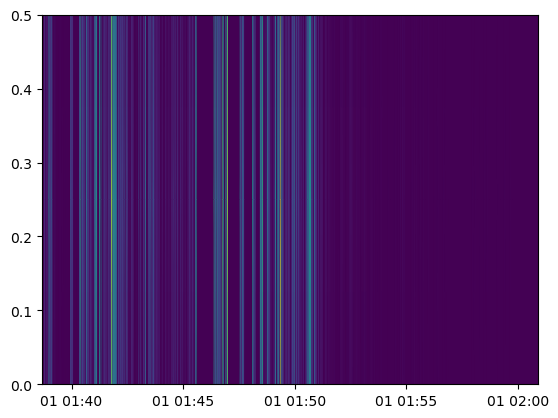

In [23]:
plt.pcolormesh(ts_dt64, frequencies, np.abs(Sxx_e), shading='gouraud')  # np.abs(Sxx_e) have 0 values

In [25]:

## --- get the cross spectral
cpsd = Sxx_e * np.conj(Sxx_b)

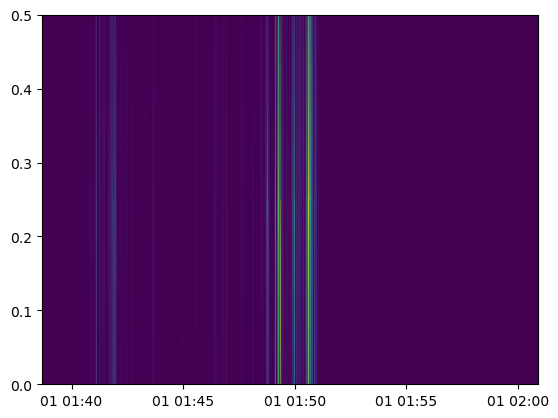

In [26]:
plt.pcolormesh(ts_dt64, frequencies, np.abs(cpsd), shading='gouraud')

In [27]:

# --- get lat and MLT

latitudes = df["glat"].values
mlts = df["sc_aacgm_ltime"].values  # note that all column names are lowercase. also get apex

In [28]:

#  --- use new method to get Coherency ---
segment_length_sec = 11  # 越大最后得到的数组的长度越小，取和之前的spectrogram输入的窗口长度是一个不错的选择，但要考虑采样率的影响
try:
    mid_times_all, avg_complex_coh = pyaw.utils.calculate_segmented_complex_coherency(
        datetimes,
        b_sc2,
        E_sc1,
        fs=fs,
        segment_length_sec=segment_length_sec,
        nfft_coh=int(
            fs * segment_length_sec * 0.5
        ),  # Use segment_length_sec/2 second FFT within segments
    )
    # Extract magnitude and phase from the complex result
    avg_coh_magnitude = np.abs(avg_complex_coh)

except ValueError as e:
    print(f"Error calculating Coherency: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [31]:

# --- 1st plot
## --- define
subplot_defs = [
    {
        "plot_type": "line",
        "x_data": datetimes,
        "y_data": b_sc2,
        "label": r"$\Delta B_{East}$",
        "title": "East Component of Disturb Magnetic Field",
        "ylabel": "Magnetic Flux Density (nT)",
        "linewidth": 1.8,
    },  # Slightly thicker line
    {
        "plot_type": "line",
        "x_data": datetimes,  # Assuming same time base for E-field line plot
        "y_data": E_sc1,
        "label": r"$E_{North}$",
        "title": "Northward Component of Electric Field",
        "ylabel": "Electric Field Strength (mV/m)",
        "linewidth": 1.8,
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": np.abs(Sxx_b),
        "title": "Power Spectral Density of East Component of Disturb Magnetic Field",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}(P_{{\Delta B}_{East}})$",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
        # 'cmap': 'plasma' # Example local override
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": np.abs(Sxx_e),
        "title": "Power Spectral Density of Northward Component of Electric Field",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}(P_{E_{North}})$",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": np.abs(cpsd),
        "title": r"The Module of Cross Power Spectral Density of $\Delta B_{East}$ and $E_{North}$",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}$(cpsd_module)",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
        # 'vmin': -50 # Example local override for clim
    },
    {
        "plot_type": "line",
        "x_data": mid_times_all,
        "y_data": avg_coh_magnitude,
        "label": r"Coherency",
        "title": "Coherency of $\Delta B_{East}$ and $E_{North}$",
        "ylabel": "Coherency (Unit 1)",
        "linewidth": 1.8,
    },
]

In [32]:

# #  Add blocks specific to certain plots
# for subplot_def in subplot_defs[:2]:
#     subplot_def["blocks"] = [
#         {
#             "start": np.datetime64("2016-03-11 06:47:05"),
#             "end": np.datetime64("2016-03-11 06:47:25"),
#             "color": "#004488",
#             "label": "Static Region",
#         },
#         {
#             "start": np.datetime64("2016-03-11 06:47:35"),
#             "end": np.datetime64("2016-03-11 06:47:55"),
#             "color": "#DDAA33",
#             "label": "Dynamic Region",
#         },
#     ]
# for subplot_def in subplot_defs[2:-1]:
#     subplot_def["vlines"] = {
#         "Static Region Start": np.datetime64("2016-03-11 06:47:05"),
#         "Static Region End": np.datetime64("2016-03-11 06:47:25"),
#         "Dynamic Region Start": np.datetime64("2016-03-11 06:47:35"),
#         "Dynamic Region End": np.datetime64("2016-03-11 06:47:55"),
#     }
# subplot_defs[-1]["blocks"] = [
#     {
#         "start": np.datetime64("2016-03-11 06:47:05"),
#         "end": np.datetime64("2016-03-11 06:47:25"),
#         "color": "#004488",
#         "label": "Static Region",
#     },
#     {
#         "start": np.datetime64("2016-03-11 06:47:35"),
#         "end": np.datetime64("2016-03-11 06:47:55"),
#         "color": "#DDAA33",
#         "label": "Dynamic Region",
#     },
# ]
subplot_defs[-1]["hlines"] = [{"y": 0.5, "color": "magenta", "linestyle": "-."}]

In [33]:

#  --- Define Aux Data for X labels ---
aux_data_for_x = {"Lat": latitudes, "MLT": mlts}

In [34]:

#   **Use Matplotlib Styles:** Apply a style *before* calling the plot function for a consistent, often publication-ready look.
plt.style.use("seaborn-v0_8-paper")  # Good for papers
# Other options: 'ggplot', 'seaborn-v0_8-talk', 'default'
# See available: print(plt.style.available)

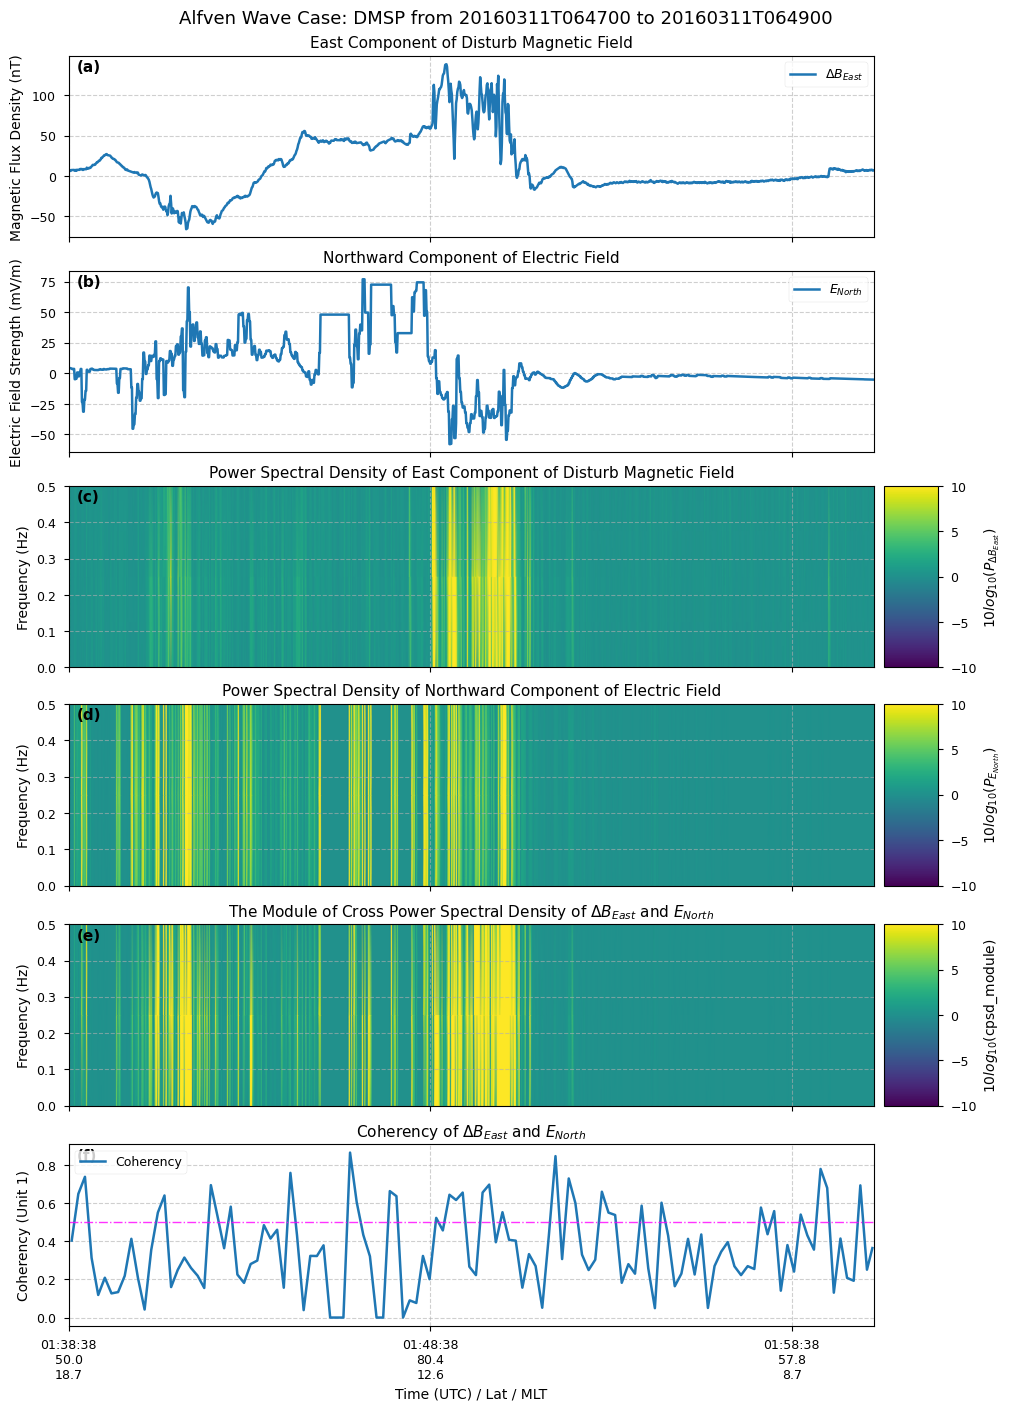

In [35]:


#  --- Call the function ---
fig, axes = plot_multi_panel(
    subplot_definitions=subplot_defs,
    x_datetime_ref=datetimes,  # Reference times for aux data (note that lats,mlts based on datetimes not tsdt64)
    x_aux_data=aux_data_for_x,  # The aux data arrays
    x_label_step=600,  # Show label every N points
    figsize=(10, 14),
    figure_title="Alfven Wave Case: DMSP from 20160311T064700 to 20160311T064900",
    # global_cmap=matplotlib.rcParams["image.cmap"],  # default
    global_cmap="viridis",
    global_vmin=-10,  # Example: Manually set global limits
    global_vmax=10,
    use_shared_clims=True,  # Use calculated shared limits unless overridden
    rotate_xticklabels=0,  # Keep horizontal for concise formatter
    # font size
    title_fontsize=11,
    label_fontsize=10,
    tick_label_fontsize=9,
    legend_fontsize=9,
    annotation_fontsize=8,
    panel_label_fontsize=11,  # Control (a), (b)... size
)

In [ ]:

#  --- Save the figure with high DPI AFTER creating it ---
output_filename_png = "dmsp.png"
print(f"Saving figure to {output_filename_png} (300 DPI)")
fig.savefig(output_filename_png, dpi=300, bbox_inches="tight")

# dynamic

In [36]:

# --- dynamic region ---
st_dy = np.datetime64("2014-01-01T01:49:00")
et_dy = np.datetime64("2014-01-01T01:51:00")
t_mask = (datetimes >= st_dy) & (datetimes <= et_dy)
datetimes_dy = datetimes[t_mask]
b_sc2_dy = b_sc2[t_mask]
E_sc1_dy = E_sc1[t_mask]

## psd

In [42]:

## --- psd ---

nperseg_psd = 64  # renew nperseg
noverlap_psd = nperseg // 2  # renew noverlap

In [43]:
b_sc2_dy_psd = pyaw.utils.PSD(
    b_sc2_dy,
    fs=fs,
    nperseg=nperseg_psd,
    noverlap=noverlap_psd,
    window=window,
    scaling="density",
)  # same arguments setting as spectrogram
E_sc1_dy_psd = pyaw.utils.PSD(
    E_sc1_dy,
    fs=fs,
    nperseg=nperseg_psd,
    noverlap=noverlap_psd,
    window=window,
    scaling="density",
)
frequencies_psd_dy, Pxx_b_sc2_dy = b_sc2_dy_psd.get_psd()
_, Pxx_E_sc1_dy = E_sc1_dy_psd.get_psd()

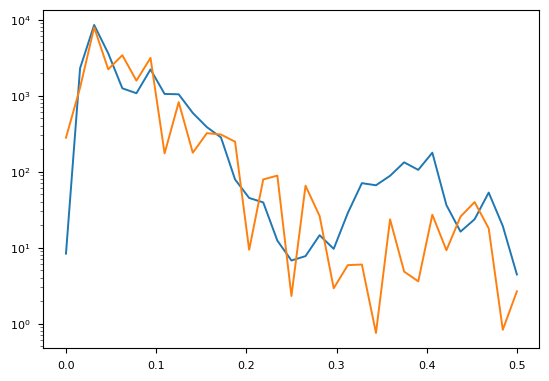

In [46]:
plt.plot(frequencies_psd_dy, Pxx_E_sc1_dy)
plt.plot(frequencies_psd_dy, Pxx_b_sc2_dy)
plt.yscale('log')

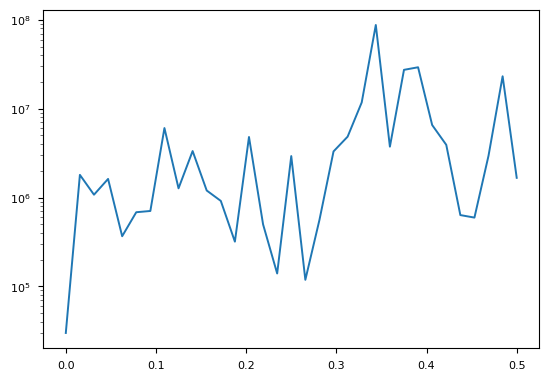

In [82]:
plt.plot(frequencies_psd_dy, Pxx_E_sc1_dy / Pxx_b_sc2_dy * 1e6)
plt.yscale('log')

## cpsd

In [58]:
nperseg_dy = 16

In [59]:

## --- cpsd ---
frequencies_spec_dy, ts_dy, Sxx_b_dy = spectrogram(
    b_sc2_dy,
    fs=fs,
    window=window,
    nperseg=nperseg_dy,
    noverlap=noverlap,
    mode="complex",
)
_, _, Sxx_e_dy = spectrogram(
    E_sc1_dy, fs=fs, window=window,
    nperseg=nperseg_dy,
    noverlap=noverlap,
    mode="complex"
)

In [60]:

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), "s") for _ in ts_dy]

In [61]:

cpsd_dy = Sxx_e_dy * np.conj(Sxx_b_dy)

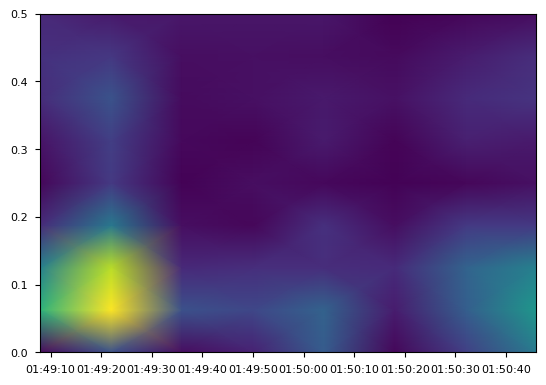

In [62]:
plt.pcolormesh(ts_dt64_dy, frequencies_spec_dy, np.abs(Sxx_e_dy), shading="gouraud")

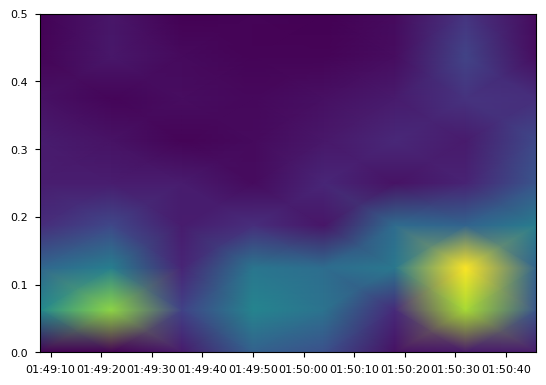

In [63]:
plt.pcolormesh(ts_dt64_dy, frequencies_spec_dy, np.abs(Sxx_b_dy), shading="gouraud")

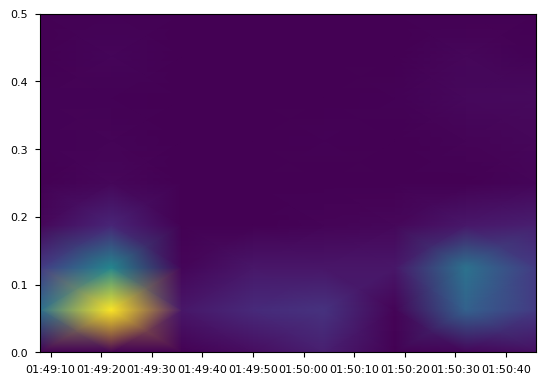

In [64]:
plt.pcolormesh(ts_dt64_dy, frequencies_spec_dy, np.abs(cpsd_dy), shading="gouraud")

In [103]:

## --- phase difference between b and E ---

num_bins = 50
cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy[cpsd_m_dy < 0.3] = np.nan  # threshold
phase_bins_dy, phase_histogram2d_dy = pyaw.utils.get_phase_histogram2d(
    frequencies_spec_dy, cpsd_phase_dy, num_bins=num_bins
)

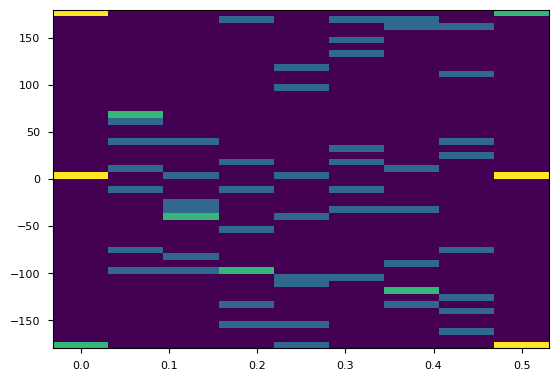

In [104]:
plt.pcolormesh(frequencies_spec_dy, (phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, phase_histogram2d_dy.T)

# static

In [73]:

# --- static region ---
st_sta = np.datetime64("2014-01-01T01:56:00")
et_sta = np.datetime64("2014-01-01T01:58:00")
t_mask = (datetimes >= st_sta) & (datetimes <= et_sta)
datetimes_sta = datetimes[t_mask]
b_sc2_sta = b_sc2[t_mask]
E_sc1_sta = E_sc1[t_mask]

In [74]:
## --- psd ---

nperseg_psd = 64  # renew nperseg
noverlap_psd = nperseg // 2  # renew noverlap

## psd

In [75]:
## --- pad ---
b_sc2_sta_psd = pyaw.utils.PSD(
    b_sc2_sta,
    fs=fs,
    nperseg=nperseg_psd,
    noverlap=noverlap_psd,
    window=window,
    scaling="density",
)
E_sc1_sta_psd = pyaw.utils.PSD(
    E_sc1_sta,
    fs=fs,
    nperseg=nperseg_psd,
    noverlap=noverlap_psd,
    window=window,
    scaling="density",
)

frequencies_psd_sta, Pxx_b_sc2_sta = b_sc2_sta_psd.get_psd()
_, Pxx_E_sc1_sta = E_sc1_sta_psd.get_psd()

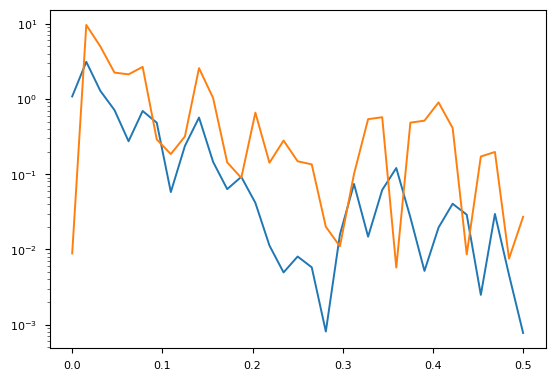

In [79]:
plt.plot(frequencies_psd_sta, Pxx_E_sc1_sta)
plt.plot(frequencies_psd_sta, Pxx_b_sc2_sta)
plt.yscale('log')

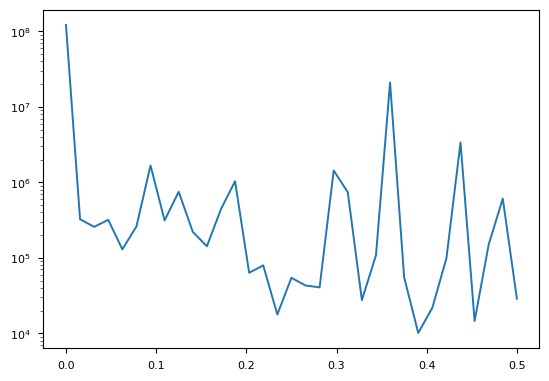

In [83]:
plt.plot(frequencies_psd_sta, Pxx_E_sc1_sta / Pxx_b_sc2_sta * 1e6)
plt.yscale('log')


## cpsd

In [76]:
nperseg_sta = 16

In [77]:
## --- cpsd ---

frequencies_spec_sta, ts_sta, Sxx_b_sta = spectrogram(
    b_sc2_sta,
    fs=fs,
    window=window,
    nperseg=nperseg_sta,
    noverlap=noverlap,
    mode="complex",
)
_, _, Sxx_e_sta = spectrogram(
    E_sc1_sta,
    fs=fs,
    window=window,
    nperseg=nperseg_sta,
    noverlap=noverlap,
    mode="complex",
)

In [78]:

ts_dt64_sta = datetimes_sta[0] + [np.timedelta64(int(_), "s") for _ in ts_sta]

In [86]:

cpsd_sta = Sxx_e_sta * np.conj(Sxx_b_sta)

In [93]:

## --- phase difference between b and E ---

cpsd_phase_sta = np.degrees(np.angle(cpsd_sta))
cpsd_m_sta = np.abs(cpsd_sta)
cpsd_phase_sta[cpsd_m_sta < 0.3] = np.nan  # threshold
phase_bins_sta, phase_histogram2d_sta = pyaw.utils.get_phase_histogram2d(
    frequencies_spec_sta, cpsd_phase_sta, num_bins=num_bins
)

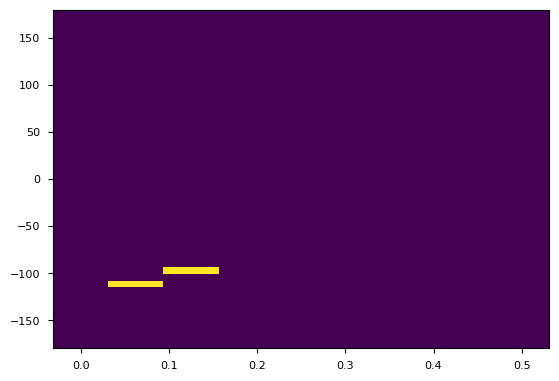

In [94]:
plt.pcolormesh(frequencies_spec_sta, (phase_bins_sta[:-1] + phase_bins_sta[1:]) / 2, phase_histogram2d_sta.T)

In [105]:

# --- ratio ---

eb_ratio_psd_dy = (
        (Pxx_E_sc1_dy / Pxx_b_sc2_dy) * 1e-3 * 1e9
)  # transform unit
eb_ratio_psd_sta = (Pxx_E_sc1_sta / Pxx_b_sc2_sta) * 1e-3 * 1e9

In [106]:

# --- lower and upper bound
from src.pyaw import (
    PhysicalParameters,
    calculate_lower_bound,
    calculate_upper_bound,
    calculate_R,
    calculate_phase_vary_range,
)

mu0 = PhysicalParameters.mu0
Sigma_P_dy = 3.0
Sigma_P_sta = 0.5
va_dy = 1.4e6
va_sta = 1.3e6

boundary_l_dy = calculate_lower_bound(Sigma_P_dy)
boundary_h_dy = calculate_upper_bound(va_dy, Sigma_P_dy)
print(f"boundary_l_dy*mu0: {boundary_l_dy * mu0}")
print(f"boundary_h_dy*mu0: {boundary_h_dy * mu0}")

boundary_l_sta = calculate_lower_bound(Sigma_P_sta)
boundary_h_sta = calculate_upper_bound(va_sta, Sigma_P_sta)
print(f"boundary_l_sta*mu0: {boundary_l_sta * mu0}")
print(f"boundary_h_sta*mu0: {boundary_h_sta * mu0}")

reflection_coef_dy = calculate_R(v_A=va_dy, Sigma_P=Sigma_P_dy)
reflection_coef_sta = calculate_R(v_A=va_sta, Sigma_P=Sigma_P_sta)

phase_vary_range_dy = calculate_phase_vary_range(reflection_coef_dy)
phase_vary_range_sta = calculate_phase_vary_range(reflection_coef_sta)
print(f"phase_vary_range_dy: {phase_vary_range_dy}")
print(f"phase_vary_range_sta: {phase_vary_range_sta}")

boundary_l_dy*mu0: 0.3333333333333333
boundary_h_dy*mu0: 9.28532381410286
boundary_l_sta*mu0: 2.0
boundary_h_sta*mu0: 1.3343705141015165
phase_vary_range_dy: (68.54267010140487, -68.54267010140487)
phase_vary_range_sta: (-11.515132136491069, 11.515132136491069)


In [107]:

# --- plot ---
nrows, ncols_main = 4, 2
plot_defs = [[None for _ in range(ncols_main)] for _ in range(nrows)]
# Row 0
plot_defs[0][0] = {
    "plot_type": "line",
    "x_data": datetimes_sta,
    "y_data_list": [
        E_sc1_sta,
        b_sc2_sta,
    ],  # 先用蓝色绘制电场，在用橙色绘制磁场
    "linewidth": 1.8,
    "labels": [r"$E_{North}$", r"$\Delta_{B_{East}}$"],
    "title": "Static Region from 064705 to 064725",
    "xlabel": "Time (UTC)",
    "ylabel": "Amp",
}
plot_defs[0][1] = {
    "plot_type": "line",
    "x_data": datetimes_dy,
    "y_data_list": [E_sc1_dy, b_sc2_dy],
    "labels": [r"$E_{North}$", r"$\Delta_{B_{East}}$"],
    "title": "Dynamic Region from 064735 to 064755",
    "xlabel": "Time (UTC)",
    "ylabel": "Amp",
}
# Row 1
plot_defs[1][0] = {
    "plot_type": "line",
    "x_data": frequencies_psd_sta,
    "y_data_list": [Pxx_E_sc1_sta, Pxx_b_sc2_sta],
    "labels": [r"PSD of $E_{North}$", r"PSD of $\Delta_{B_{East}}$"],
    "yscale": "log",  # Use log scale
    "title": "PSD of $\Delta_{B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "PSD",
}
plot_defs[1][1] = {
    "plot_type": "line",
    "x_data": frequencies_psd_dy,
    "y_data_list": [Pxx_E_sc1_dy, Pxx_b_sc2_dy],
    "labels": [r"PSD of $E_{North}$", r"PSD of $\Delta_{B_{East}}$"],
    "yscale": "log",  # Use log scale
    "title": "PSD of $\Delta_{B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "PSD",
}
# Row 2
plot_defs[2][0] = {
    "plot_type": "line",
    "x_data": frequencies_psd_sta,
    "y_data_list": [eb_ratio_psd_sta],
    "yscale": "log",  # Use log scale
    "labels": [r"ratio of $\frac{E_{North}}{\Delta_{B_{East}}}$"],
    "title": r"ratio of  $\frac{E_{North}}{\Delta_{B_{East}}}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "ratio",
    "hlines": [
        {"y": boundary_l_sta, "label": r"$1/(\mu_0 \Sigma_P)$"},
        {
            "y": boundary_h_sta,
            "label": r"$\mu_0 va^2 \Sigma_P$",
        },
        {"y": va_sta, "label": r"$v_A$"},
    ],
}
plot_defs[2][1] = {
    "plot_type": "line",
    "x_data": frequencies_psd_dy,
    "y_data_list": [eb_ratio_psd_dy],
    "yscale": "log",
    "labels": [r"ratio of  $\frac{E_{North}}{\Delta_{B_{East}}}$"],
    "title": r"ratio of $\frac{E_{North}}{\Delta_{B_{East}}}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "ratio",
    "hlines": [
        {"y": boundary_l_dy, "label": r"$1/(\mu_0 \Sigma_P)$"},
        {
            "y": boundary_h_dy,
            "label": r"$\mu_0 va^2 \Sigma_P$",
        },
        {"y": va_dy, "label": r"$v_A$"},
    ],
}  # Normal line plot here
# Row 3
plot_defs[3][0] = {
    "plot_type": "pcolormesh",
    "x_data": frequencies_spec_sta,
    "y_data": (phase_bins_sta[:-1] + phase_bins_sta[1:]) / 2,
    "z_data": phase_histogram2d_sta.T,
    "title": "The Occurrence of Phase Difference between\n$\Delta_{B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "Phase Difference (Degree)",
    "shading": "auto",
    "hlines": [{"y": -10}, {"y": 10}],
}
plot_defs[3][1] = {
    "plot_type": "pcolormesh",
    "x_data": frequencies_spec_dy,
    "y_data": (phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2,
    "z_data": phase_histogram2d_dy.T,
    "title": "The Occurrence of Phase Difference between\n$\Delta_{B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "Phase Difference (Degree)",
    "shading": "auto",
    "hlines": [{"y": -68}, {"y": 68}],
}

Calculating shared color limits...
 Calculated shared vmin=0.00, vmax=2.00 (raw data)


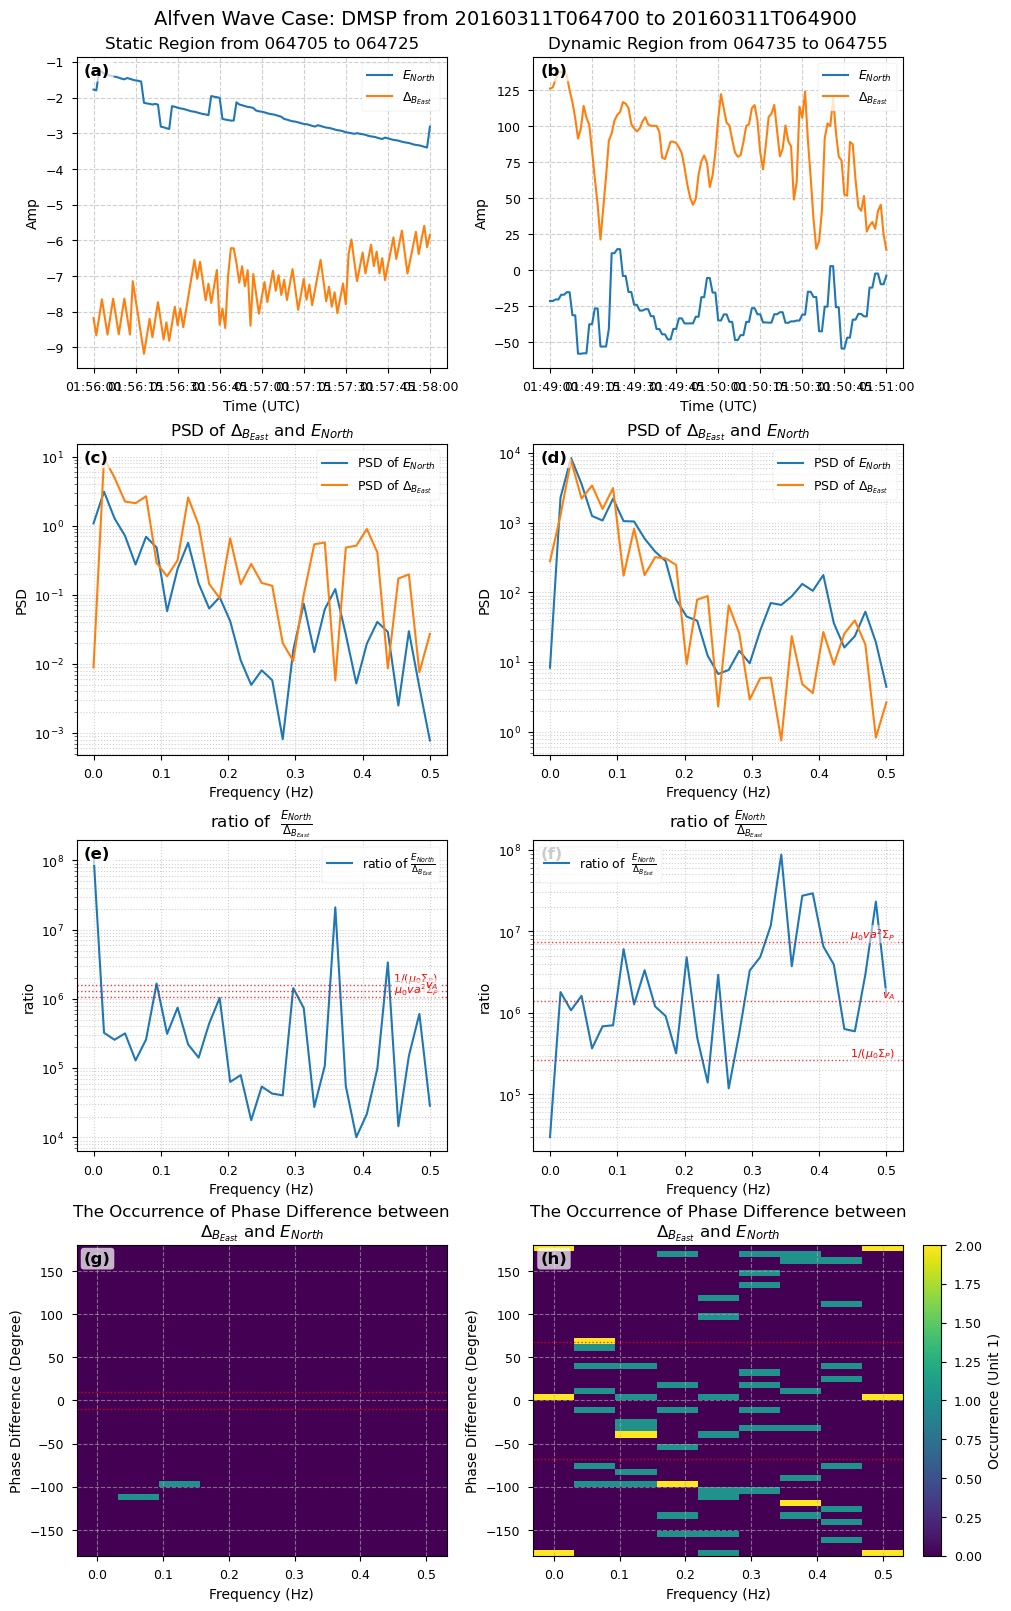

In [108]:
# style
plt.style.use("seaborn-v0_8-paper")  # Good for papers
fig, axes = plot_gridded_panels(
    plot_definitions=plot_defs,
    nrows=4,
    ncols_main=2,
    add_shared_cbar=True,
    shared_cbar_label="Occurrence (Unit 1)",
    figure_title="Alfven Wave Case: DMSP from 20160311T064700 to 20160311T064900",
    figsize=(10, 16),  # Adjust size
    use_shared_clims=True,  # Use shared clim for spectrograms
)

In [ ]:

plt.savefig("dmsp_case.png", dpi=300, bbox_inches="tight")